<a href="https://colab.research.google.com/github/arvizu-god/dg-ssp/blob/main/DG_SSP_070425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Started on 07-04-2025

In [8]:
!pip install qiskit qiskit-aer pylatexenc

In [9]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import MCXGate,MCMTGate,ZGate, QFT
from qiskit_aer import AerSimulator,QasmSimulator
import numpy as np
import math
import matplotlib.pyplot as plt

In [10]:
def dg_ssp(a,t):

    n_ind=len(a)
    n_sum=int(np.ceil(np.log2(sum(a)+1)))

    ind_reg=QuantumRegister(n_ind,'i')
    sum_reg=QuantumRegister(n_sum,'s')
    anc_reg=QuantumRegister(1,'a')
    mea_reg=ClassicalRegister(n_ind,'m')

    qc=QuantumCircuit(ind_reg,sum_reg,anc_reg,mea_reg)


    def adder(control,a):
        qc.append(QFT(n_sum,do_swaps=False).to_gate(label='QFT'),sum_reg)
        for i in range(n_sum):
            angle=(2*np.pi*a)/(2**(i+1))
            qc.cp(angle,control,sum_reg[i])
        qc.append(QFT(n_sum,do_swaps=False).inverse().to_gate(label='QFT†'),sum_reg)
        qc.barrier()

    def substractor(control,a):
        qc.append(QFT(n_sum,do_swaps=False).to_gate(label='QFT'),sum_reg)
        for i in range(n_sum):
            angle=(2*np.pi*((-a) % (2 ** n_sum)))/(2**(i+1))
            qc.cp(angle,control,sum_reg[i])
        qc.append(QFT(n_sum,do_swaps=False).inverse().to_gate(label='QFT†'),sum_reg)
        qc.barrier()

    def oracle():
        t_bin=format(t,f'0{n_sum}b')[::-1]
        qc.x(anc_reg)
        qc.h(anc_reg)
        for i, bit in enumerate(t_bin):
            if bit=='0':
                qc.x(sum_reg[i])
        qc.mcx(sum_reg,anc_reg)
        for i, bit in enumerate(t_bin):
            if bit=='0':
                qc.x(sum_reg[i])
        qc.h(anc_reg)
        qc.x(anc_reg)
        qc.barrier()
    def oracle2():
        num_qubits=len(sum_reg)
        qc.x(anc_reg)
        qc.h(anc_reg)
        # Apply X gates conditionally if the corresponding bit in target_sum is 0
        for i in range(num_qubits):
            if ((t >> i) & 1) == 0:
                qc.x(sum_reg[i])

        # Apply the multi-controlled X gate (MCX)
        # The gate acts on all qubits in val_reg as controls and the aux_reg qubits as targets.
        #qc.append(MCXGate(num_qubits), qargs=[*sum_reg, *anc_reg])
        qc.mcx(sum_reg,anc_reg)

        # Apply the X gates again to restore the original state of val_reg (undo the earlier X gates)
        for i in range(num_qubits):
            if ((t >> i) & 1) == 0:
                qc.x(sum_reg[i])

        qc.h(anc_reg)
        qc.x(anc_reg)
        qc.barrier()

    def diffuser():
        qc.h(ind_reg)
        qc.x(ind_reg)
        qc.barrier()
        qc.h(ind_reg[-1])
        qc.mcx(ind_reg[:-1],ind_reg[-1])
        qc.h(ind_reg[-1])
        qc.barrier()
        qc.x(ind_reg)
        qc.h(ind_reg)
        qc.barrier()

    qc.h(ind_reg)
    qc.barrier()

    # Calculate the number of Grover iterations.
    r = max(1, int(np.floor(np.pi / 4 * np.sqrt(2 ** n_ind/10))))
    for _ in range(r):
        # Apply the Draper adder for each element in s.
        for i, a in enumerate(s):
            adder(ind_reg[i], a)
            #qc.barrier()
        # Compare the sum in sum_reg to the target t.
        oracle()
        #qc.barrier()
        # Uncompute (subtract) the additions.
        #for i, a in reversed(list(enumerate(s))):
        for i, a in list(enumerate(s)):
            substractor(ind_reg[i], a)
            #qc.barrier()
        # Apply the Grover diffuser.
        diffuser()
        #qc.barrier()

    # Measure the selector register.
    qc.measure(ind_reg, mea_reg)

    return qc

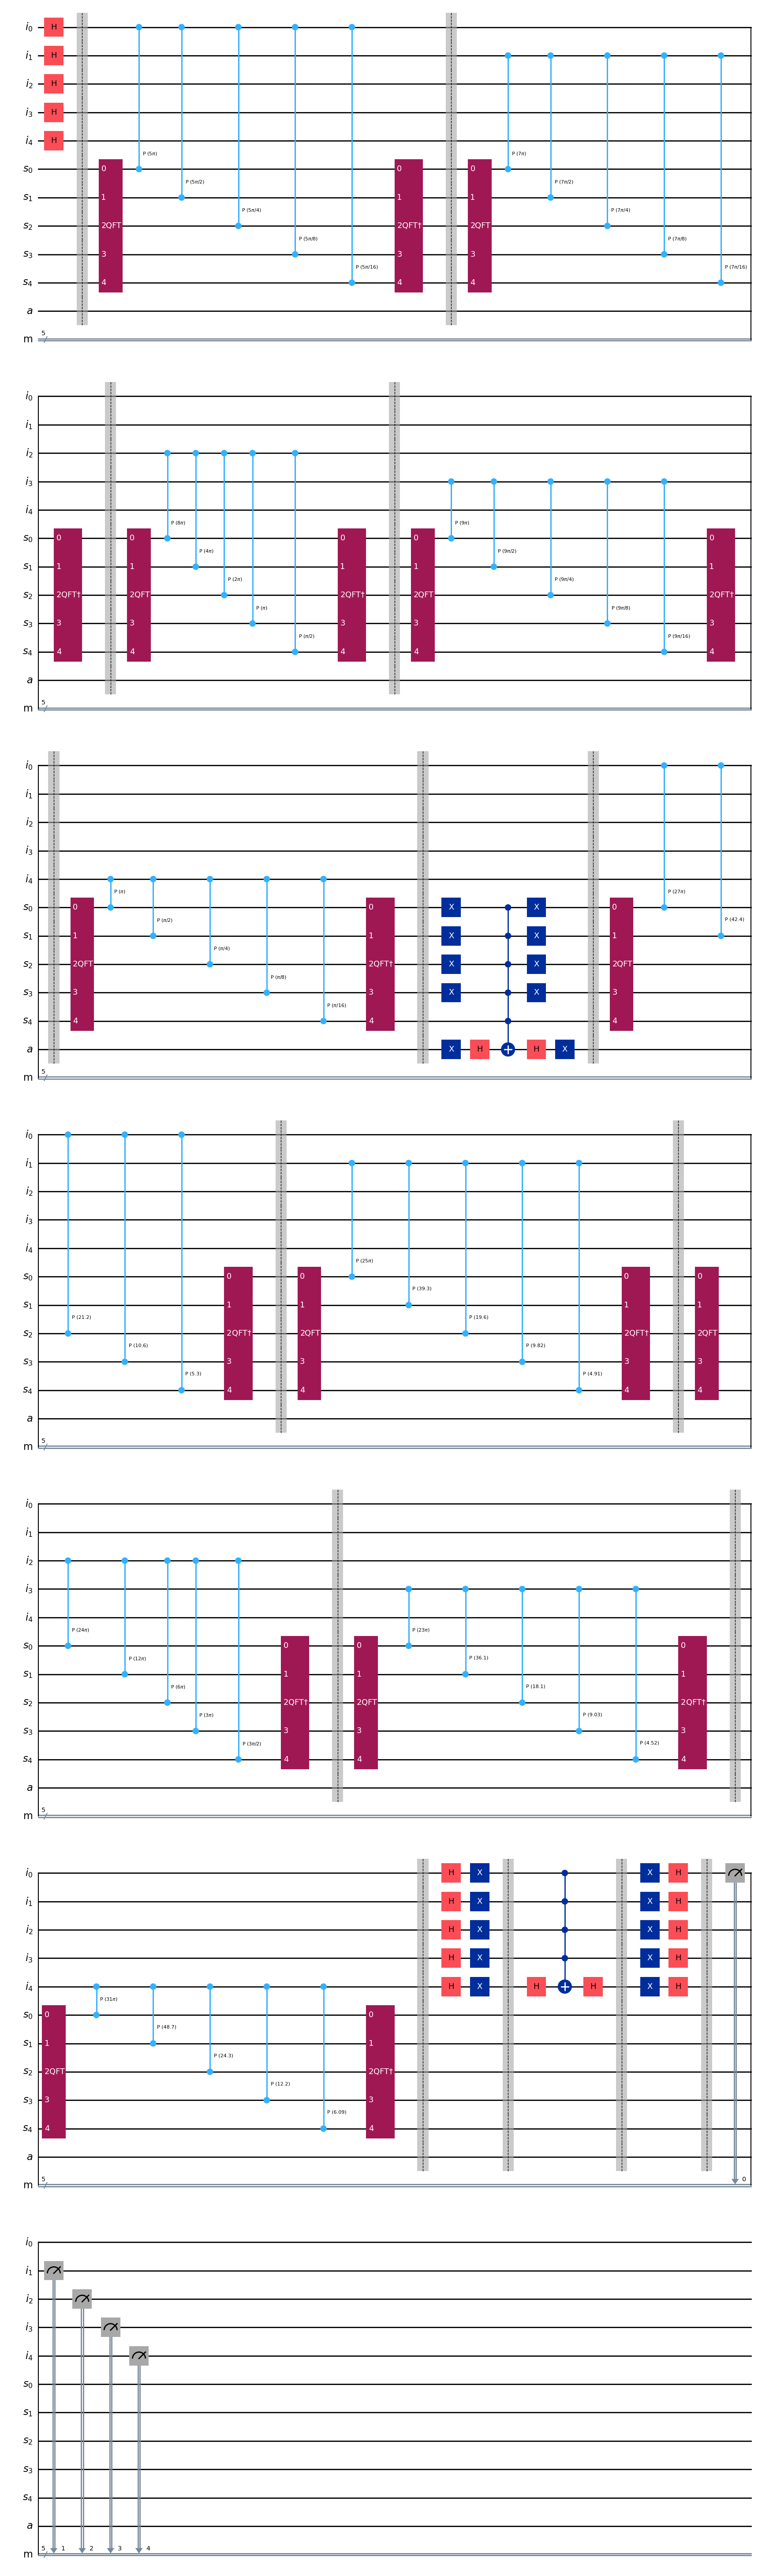

In [11]:
s =  [5, 7, 8, 9, 1]
t = 16
circuit = dg_ssp(s, t)
circuit.draw(output='mpl')

{'10101': 15, '00101': 18, '11110': 13, '10001': 19, '11010': 25, '01001': 13, '10110': 269, '10000': 29, '11111': 17, '11011': 12, '10010': 11, '11100': 12, '00110': 20, '00001': 15, '01010': 234, '11101': 19, '10111': 24, '10100': 19, '00111': 11, '00011': 13, '11000': 22, '01110': 18, '01101': 18, '01111': 15, '00000': 16, '11001': 16, '00010': 12, '01011': 18, '01000': 30, '01100': 19, '00100': 17, '10011': 15}


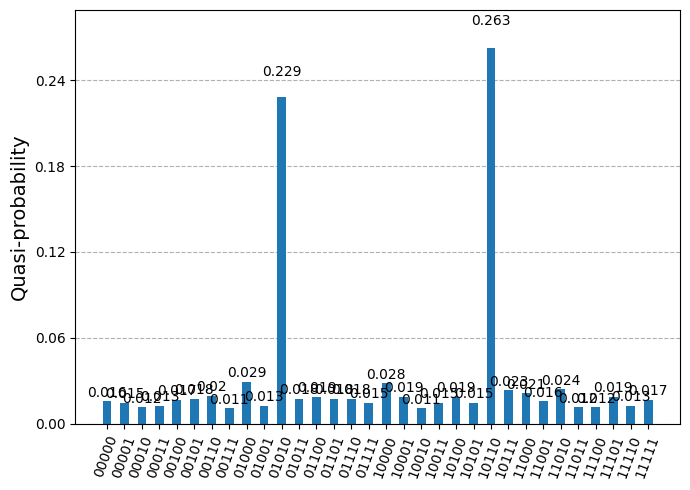

In [12]:
# Resultados
qc1=circuit.copy()
simulator=AerSimulator()
tqc=transpile(qc1,simulator)
result=simulator.run(tqc).result()
counts=result.get_counts()
print(counts)
plot_distribution(result.get_counts())

In [17]:
def results(qc,shots=2048):
    simulator=AerSimulator()
    tqc=transpile(qc,simulator)
    result=simulator.run(tqc).result()
    counts=result.get_counts()

    decoded = {}
    for bitstring, count in counts.items():
        # Reverse bitstring: rightmost bit corresponds to S[0]
        bits = bitstring[::-1]
        subset = [s[i] for i, bit in enumerate(bits) if bit == '1']
        subset_str = str(subset)
        decoded[subset_str] = count
    # Sort the decoded results by count in descending order.
    sorted_decoded = dict(sorted(decoded.items(), key=lambda x: x[1], reverse=True))

    subsets = list(sorted_decoded.keys())
    counts_values = list(sorted_decoded.values())

    plt.figure(figsize=(10, 6))
    plt.bar(subsets, counts_values, color='green')
    plt.xlabel("Subset of S")
    plt.ylabel("Counts")
    plt.title("Histogram of Measured Subsets")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return sorted_decoded

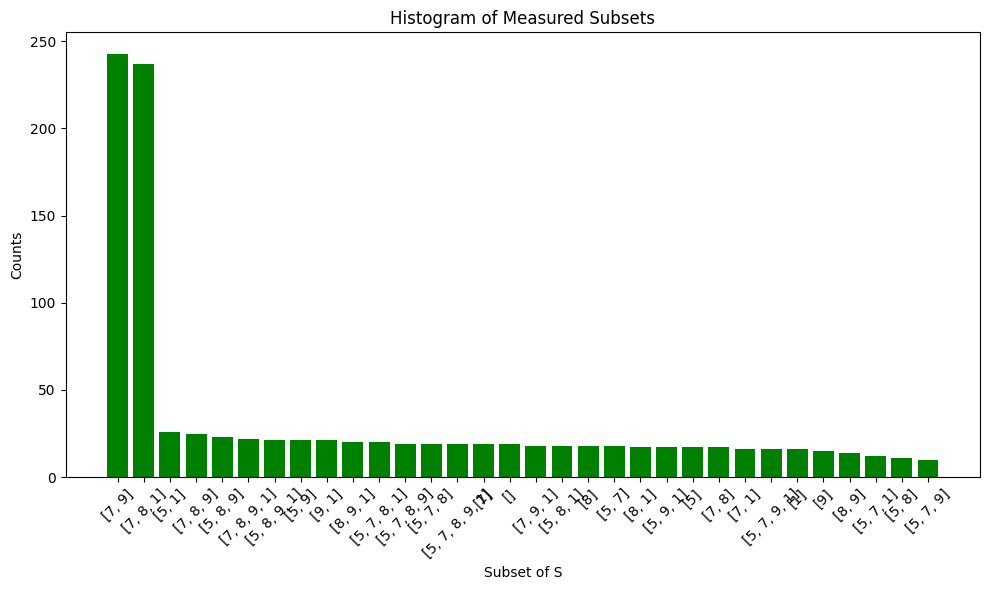

{'[7, 9]': 243,
 '[7, 8, 1]': 237,
 '[5, 1]': 26,
 '[7, 8, 9]': 25,
 '[5, 8, 9]': 23,
 '[7, 8, 9, 1]': 22,
 '[5, 8, 9, 1]': 21,
 '[5, 9]': 21,
 '[9, 1]': 21,
 '[8, 9, 1]': 20,
 '[5, 7, 8, 1]': 20,
 '[5, 7, 8, 9]': 19,
 '[5, 7, 8]': 19,
 '[5, 7, 8, 9, 1]': 19,
 '[7]': 19,
 '[]': 19,
 '[7, 9, 1]': 18,
 '[5, 8, 1]': 18,
 '[8]': 18,
 '[5, 7]': 18,
 '[8, 1]': 17,
 '[5, 9, 1]': 17,
 '[5]': 17,
 '[7, 8]': 17,
 '[7, 1]': 16,
 '[5, 7, 9, 1]': 16,
 '[1]': 16,
 '[9]': 15,
 '[8, 9]': 14,
 '[5, 7, 1]': 12,
 '[5, 8]': 11,
 '[5, 7, 9]': 10}

In [18]:
# Resultados
qc1=circuit.copy()
results(qc1)